In [1]:
import random, warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})


## CCN demonstration plots

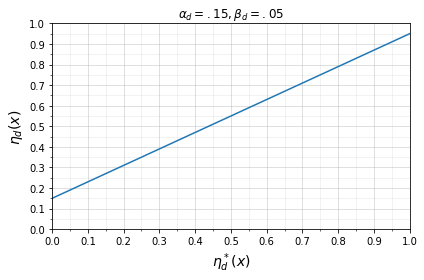

In [444]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(eta_star, eta_y)


# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.01, .1)
minor_ticks = np.arange(0, 1.01, .05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.set_xlim([0, 1])

ax.set_ylabel('$\eta_d(x)$', size=14)
ax.set_xlabel('$\eta_d^*(x)$', size=14)
ax.set_title(r'$\alpha_d=.15, \beta_d=.05$')
plt.tight_layout()
plt.savefig('true_proxy_cpf.png', dpi=400)

## Counterfactual estimation challenge intuition

In [3]:
def ccn_model(eta_star, beta, alpha):
    return (1 - beta - alpha)*eta_star + alpha

def eta(x):
    return .5 + .5 * np.sin(2.9*x + .1)

#     return np.piecewise(x,[((-1 <= x) & (x <= -.38)),
#                         ((-.38 < x) & (x <= 0.3)),
#                         ((0.3 < x) & (x <= 1))],  
#                        [lambda v: .5*np.sin(2*v +1.3) + .5, 
#                         lambda v: .1*v + -.1*np.sin(1.5*v - .23) + .5,
#                         lambda v: 1*np.sin(2*v - .13)  ])

# def pi(x, do, uniform=True, no_intervention=False):
#     if uniform: 
#         pi = np.ones(x.shape)
#     else:
#         pi = .6*(0.9 + 0.4 * np.sin(x))
    
#     if do==0 and not no_intervention:
#         pi = 1-pi
#     return pi

def pi(x, do, propfunc, no_intervention=False):
    if propfunc=='uniform': 
        pi = np.ones(x.shape)
    elif propfunc=='sine':
        pi = .6*(0.9 + 0.4 * np.sin(x))
    elif propfunc=='anchors':
        pi = np.piecewise(x,[((-1 <= x) & (x <= -.575)),
                ((-.575 < x) & (x <= 0.508)),
                ((0.508 < x) & (x <= 1))],  
                       [lambda v: -.5*v-.096, 
                        lambda v: 1/(1+np.exp(-2.5*v)),
                        lambda v: -.5*v+1.035  ])
        pi = .7*pi + .3

    if do==0 and not no_intervention:
        pi = 1-pi
    return pi
    
def plot_tcn(eta_star, rand_intervention, show_propensity, show_samples):
    f, axs = plt.subplots(1, 2, sharey=False, figsize=(14,5))
    
    N=200
    
    for d in [0,1]:

        # Apply CCN noise model
        if d == 0:
            alpha_0, beta_0 = .1, .15
            eta_y = ccn_model(eta_star, beta=alpha_0, alpha=beta_0)
        else:
            alpha_1, beta_1 = .2, .05
            eta_y = ccn_model(eta_star, beta=alpha_1, alpha=beta_1)

        #Sample propensity function
        obs_outcome = np.random.binomial(1, pi(x, do=d, uniform=rand_intervention), size=eta_y.size)

        # Sample from proxy counterfactual class probability funcion
        samples_x = x[obs_outcome==1]
        samples_y = np.random.binomial(1, eta_y[obs_outcome==1], size=eta_y[obs_outcome==1].size)
        
        # Class probability functions
        axs[d].plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
        axs[d].plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')

        # Propensity function
        if show_propensity:
            axs[d].plot(x, pi(x, do=d, uniform=rand_intervention), label='$\pi(x)$', color='orange', linestyle='--')

        # Samples
        if show_samples:
            axs[d].scatter(samples_x[samples_y==1], samples_y[samples_y==1], marker='+', color='black', label=f'$Y_{d}=1$')
            axs[d].scatter(samples_x[samples_y==0], samples_y[samples_y==0], marker='o', color='black', label=f'$Y_{d}=0$')

        # Plot grid
        axs[d].set_xticks(np.arange(-1.0, 1.02, .2), fontsize=20)
        axs[d].set_yticks(np.arange(0.0, 1.01, .2), fontsize=20)
        axs[d].grid(which='both')

        # Or if you want different settings for the grids:
        axs[d].grid(which='minor', alpha=0.2)
        axs[d].grid(which='major', alpha=0.5)
        # ax.set_xlim([0, 1])

        axs[d].set_ylabel('Probability', size=14)
        axs[d].set_xlabel('X', size=14)
        axs[d].tick_params(axis='x', labelsize=13)
        axs[d].tick_params(axis='y', labelsize=13)

        if d == 0:
            axs[d].set_title(r'D:=0, CCN($\alpha_0=.1, \beta_0=.15$)', size=14)
            axs[d].legend(prop={'size': 14}, loc='center right')
        else:
            axs[d].set_title(r'D:=1, CCN($\alpha_1=.2, \beta_1=.05$)', size=14)
            axs[d].legend(prop={'size': 14}, bbox_to_anchor=(1.02, 1))
        
    return f


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def learn_eta_hat(do, exp_dataset):

    # Partition observed data into a training and validation dataset
    data = pd.DataFrame(exp_dataset)
    te_ix = int(data.shape[0]*.7)

    train = data.iloc[:te_ix]
    train_x = train['X'][data['D'] == do].to_numpy().reshape(-1, 1)
    train_y = train['Y'][data['D'] == do].to_numpy()
    train_d = train['D'].to_numpy()

    val = data.iloc[te_ix:]
    val_x = val['X'].to_numpy().reshape(-1, 1)
    val_y = val['Y'].to_numpy()
    
    # Train model and predict probability on test set 
    clf = MLPClassifier(alpha=0, hidden_layer_sizes=(50, 3))
    clf.fit(train_x, train_y)
    
    # Train model and predict propensity on test set 
    clf_pi = MLPClassifier(alpha=0, hidden_layer_sizes=(50, 3))
    clf_pi.fit(train_x, train_d)
    
    val_py = clf.predict_proba(val_x)
    val_pd = clf_pi.predict_proba(val_x)

    return val_x, val_y, val_py, val_pd

# eta_star = np.linspace(0,1, num=100)
# eta_y = ccn_model(eta_star, beta=.05, alpha=.15)

# x = np.linspace(-1,1, num=200)
# eta_star = eta(x) # True counterfactual class probability function
# rand_intervention=False
# show_propensity=True
# show_samples=True

# f = plot_tcn(eta_star, rand_intervention=True, show_propensity=False, show_samples=False)
# f.tight_layout()
# f.savefig('tcn_a.png', dpi=400)

# f = plot_tcn(eta_star, rand_intervention=True, show_propensity=True, show_samples=True)
# f.tight_layout()
# f.savefig('tcn_b.png', dpi=400)

# f = plot_tcn(eta_star, rand_intervention=False, show_propensity=True, show_samples=True)
# f.tight_layout()
# f.savefig('tcn_c.png', dpi=400)

## Dataset sample size experiment 

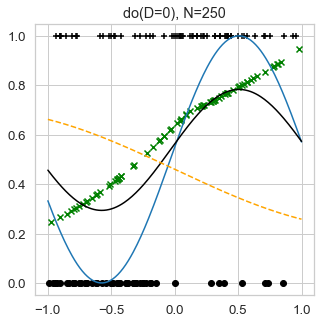

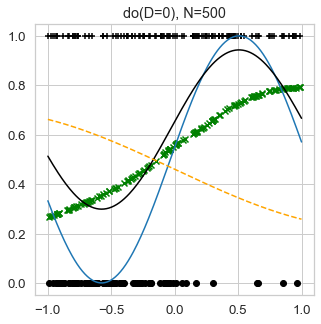

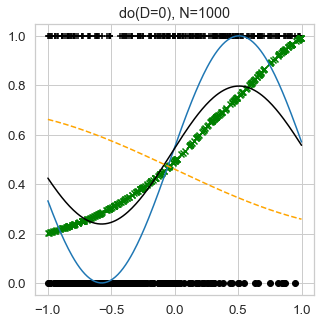

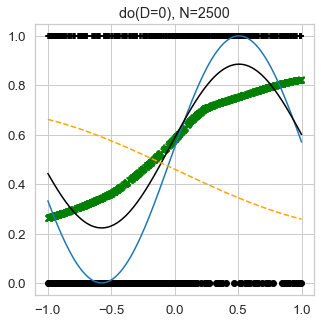

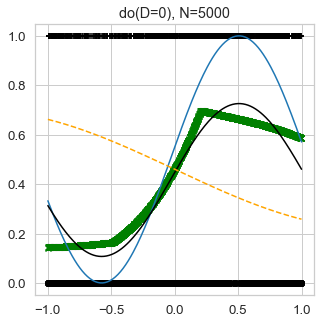

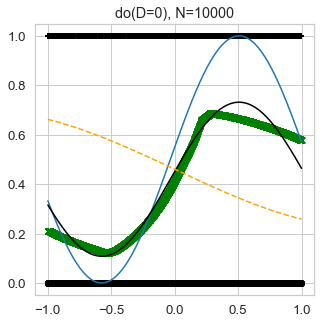

In [4]:
# N=1000

# alpha=.15
# beta=.15

xmin=-1
xmax=1
x = np.linspace(-1,1, num=200)
eta_star = eta(x)

# Configuration
uniform_propensity=False
no_intervention = False
plot=True
propfunc='sine'
dataset_sizes = [250, 500, 1000, 2500, 5000, 10000]

runs = {
    'N': [],
    'alpha': [],
    'alpha_hat': [],
    'beta': [],
    'beta_hat': [], 
    'alpha_error': [], 
    'beta_error': [],
    'total_error': [],
    'method': []
}

for N in dataset_sizes:
    for run in range(40):
        
        alpha = random.uniform(.05, .3)
        beta =  random.uniform(.05, .3)
        
        if run == 0:
            plot=True
        else:
            plot=False

        # Sample data
        xs = np.random.uniform(xmin, xmax, size=N)
        ds = np.random.binomial(1, pi(xs, do=0, propfunc=propfunc, no_intervention=no_intervention)) #make do() instead of draw
        etass = eta(xs)

        exp_dataset = {
            'X': xs,
            'D': np.zeros(xs.size),
            'Y': np.zeros(xs.size)
        }

        if plot:
            f, axs = plt.subplots(1, 1, sharey=False, figsize=(5,5))

        for d in [0]:
            # Apply CCN noise model
            if d == 0:
                eta_y = ccn_model(eta_star, beta=beta, alpha=alpha)
                pysd = ccn_model(etass, beta=beta, alpha=alpha)[ds==1]
                yobs = np.random.binomial(1, pysd)
                xsd = xs[ds==1]
                exp_dataset['Y'][ds==1] = yobs
                exp_dataset['D'][ds==1] = 0

            else:
                eta_y = ccn_model(eta_star, beta=beta, alpha=alpha)
                pysd = ccn_model(etass, beta=beta, alpha=alpha)[ds==0]
                yobs = np.random.binomial(1, pysd)
                xsd = xs[ds==0]
                exp_dataset['Y'][ds==0] = yobs
                exp_dataset['D'][ds==0] = 1
                
            val_x, val_y, val_py, val_pd = learn_eta_hat(do=d, exp_dataset=exp_dataset)
            
            # Compute estimates and errors
            pix = pi(val_x, do=d, propfunc=propfunc, no_intervention=no_intervention)
            
            for method in ['expert', 'classprob']:

                # Estimate anchor points on validation fold
                ix_min = np.argmin(val_pd[:, 1] if method == 'expert' else val_py[:,1]).astype(int)
                ix_max = np.argmax(val_pd[:, 1] if method == 'expert' else val_py[:,1]).astype(int)
                
                # Use anchor points to estimate error parameters
                alpha_hat = 1/pix[ix_min][0] * val_py[ix_min,1]
                beta_hat = 1-(1/pix[ix_max][0] * val_py[ix_max,1])
                alpha_error = np.abs(alpha_hat-alpha)
                beta_error = np.abs(beta_hat-beta)
                total_error = alpha_error+beta_error
            
                # Track error statistics
                runs['N'].append(N)
                runs['alpha'].append(alpha)
                runs['beta'].append(beta)
                runs['alpha_hat'].append(alpha_hat)
                runs['beta_hat'].append(alpha_hat)
                runs['alpha_error'].append(alpha_error)
                runs['beta_error'].append(beta_error)
                runs['total_error'].append(total_error)
                runs['method'].append(method)
            
            if plot:
                # Class probability functions
                axs.plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
                axs.plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')

                # Propensity function
                pix = pi(x, do=d, propfunc=propfunc, no_intervention=no_intervention)
                axs.plot(x, pix, label='$\pi(x)$', color='orange', linestyle='--')

                # Samples 
                axs.scatter(xsd[yobs==1], yobs[yobs==1], marker='+', color='black', label=f'$Y_{d}=1$')
                axs.scatter(xsd[yobs==0], yobs[yobs==0], marker='o', color='black', label=f'$Y_{d}=1$')

                # Samples 
                pix = pi(val_x, do=d, propfunc=propfunc, no_intervention=no_intervention)
                axs.scatter(val_x, 1/pix.squeeze() * val_py[:,1], marker='x', color='green', label=f'$P[Y]$')
                plt.title(f'do(D={d}), N={N}')
                


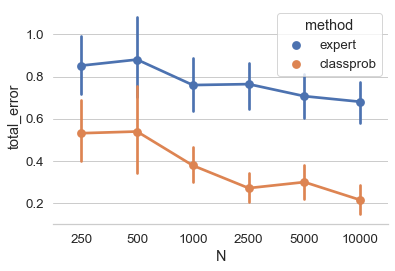

In [5]:
runslog = pd.DataFrame(runs)
sns.pointplot(data=runslog, x='N', y='total_error', hue='method', palette="deep")
sns.despine(left=True)


<AxesSubplot:xlabel='N', ylabel='error'>

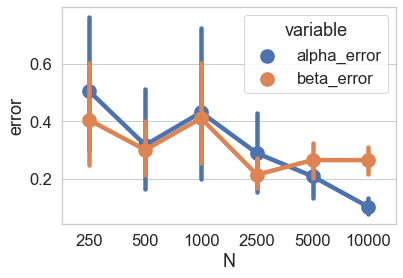

In [119]:
runserrors = pd.melt(runslog, id_vars=['N', 'alpha', 'beta', 'alpha_hat', 'beta_hat', 'total_error', 'method'],
        value_vars=['alpha_error', 'beta_error'], value_name='error')

data = runserrors[runserrors['method']=='classprob']
sns.pointplot(data=data, x='N', y='error', hue='variable', palette="deep")


## Confident learning example

In [146]:
C_hat = np.zeros((2,2))
Q_hat = np.zeros((2,2))
t = py_val.mean(axis=0)

In [147]:
for i in [0, 1]:
    for j in [0, 1]:
        C[i][j] = (py_val[val_y == i][:,j] >= t[j]).sum()
        
for i in [0, 1]:
    for j in [0, 1]:
        Q_hat[i][j] = (C[i,j]/C[i,:].sum()) * (val_y == i).sum()
        

Q_hat = Q_hat/Q_hat.sum()
beta_hat = Q_hat[0, 1] / Q_hat[:, 1].sum()
alpha_hat = Q_hat[1, 0] / Q_hat[:, 0].sum()

In [150]:
alpha_hat

0.1698868581375109

In [149]:
beta_hat

0.20911270983213429